**Start a simple Spark Session**

In [1]:
# Installation & Spark Initialization
!pip -q install pyspark

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("JSON-RDD-avg")
         .master("local[*]")
         .getOrCreate())
sc = spark.sparkContext
print("Spark session started")


Spark session started


**The code loads flight data with Spark, rdd, filters valid delays, computes the average departure delay per origin airport using combineByKey, and prints the top 10 airports with the highest average delay.**

In [2]:
import csv
from google.colab import files


uploaded = files.upload()
# read CSV and parse each line
rdd = sc.textFile("flights_2000.csv") \
        .map(lambda line: next(csv.reader([line])))

header = rdd.first()

rdd = rdd.filter(lambda row: row != header)  # remove header
# adjust field indexes according to CSV columns
origin_idx = 3
delay_idx = 6

pairs = (
    rdd
    .filter(lambda a: a[delay_idx] != "")       # drop empty delay values
    .map(lambda a: (a[origin_idx], float(a[delay_idx])))  # convert delay to float
)

#initializes an accumulator per key
def create_comb(d):
  return(d,1)

#adds a new value to an existing accumulator
def merge_val(acc,d):
  return(acc[0] + d, acc[1] + 1)

#merges accumulators from different partitions
def merge_comb(acc1,acc2):
  return(acc1[0] + acc2[0], acc1[1] + acc2[1])

avg_rdd = (pairs.combineByKey(create_comb, merge_val, merge_comb).mapValues(lambda acc: acc[0]/acc[1]))

top10_avg_rdd = avg_rdd.takeOrdered(10, key=lambda x: -x[1])

for airport, avg_delay in top10_avg_rdd:
    print(f"{airport}: {avg_delay:.2f}")



Saving flights_2000.csv to flights_2000.csv
DFW: 11.98
JFK: 11.20
SEA: 9.56
ORD: 9.35
LAS: 9.11
CLT: 8.82
MCO: 8.69
BOS: 8.63
DEN: 8.44
MIA: 8.26


**counting total and first action time and the average time of 3 runs**



In [3]:
import time

def run_computation():
    start_total = time.time()

    start_first = time.time()
    _ = avg_rdd.count()
    first_action_time = time.time() - start_first

    result = avg_rdd.takeOrdered(10, key=lambda x: -x[1])

    total_time = time.time() - start_total
    return total_time, first_action_time, result

total_times = []
first_times = []

print("\n---- Εκτέλεση 5 φορών ----")
for i in range(5):
    t_total, t_first, res = run_computation()
    total_times.append(t_total)
    first_times.append(t_first)
    final_result = res
    print(f"Run {i+1}: total={t_total:.4f}s | first action={t_first:.4f}s")


total_filtered = sorted(total_times)[1:-1]
first_filtered = sorted(first_times)[1:-1]

avg_total = sum(total_filtered) / len(total_filtered)
avg_first = sum(first_filtered) / len(first_filtered)

print("\n---- ΤΕΛΙΚΑ ΣΥΜΠΕΡΑΣΜΑΤΑ ----")
print(f"Μέσος συνολικός χρόνος (3 runs): {avg_total:.4f}s")
print(f"Μέσος χρόνος πρώτου action (3 runs): {avg_first:.4f}s")

print("\nTop-10 αποτέλεσμα τελευταίας εκτέλεσης:")
for airport, avg_delay in final_result:
    print(f"{airport}: {avg_delay:.2f}")



---- Εκτέλεση 5 φορών ----
Run 1: total=0.9180s | first action=0.4675s
Run 2: total=0.7505s | first action=0.3663s
Run 3: total=0.8488s | first action=0.4464s
Run 4: total=1.0203s | first action=0.4990s
Run 5: total=0.9978s | first action=0.4881s

---- ΤΕΛΙΚΑ ΣΥΜΠΕΡΑΣΜΑΤΑ ----
Μέσος συνολικός χρόνος (3 runs): 0.9215s
Μέσος χρόνος πρώτου action (3 runs): 0.4673s

Top-10 αποτέλεσμα τελευταίας εκτέλεσης:
DFW: 11.98
JFK: 11.20
SEA: 9.56
ORD: 9.35
LAS: 9.11
CLT: 8.82
MCO: 8.69
BOS: 8.63
DEN: 8.44
MIA: 8.26


**The code loads the flights dataset as a Spark DataFrame, filters valid non-cancelled records, computes the average departure delay for each route, and displays the top 10 routes with the highest delay.**

In [4]:
import csv

from google.colab import files
uploaded = files.upload()

csv_path = "flights_2000.csv"   # (γράψε το όνομα ακριβώς)

df = spark.read.csv(csv_path, header=True, inferSchema=True)

df.printSchema()

from pyspark.sql.functions import col, avg

clean_df = (
    df.filter(col("CANCELLED") == 0)       # κρατάμε μόνο non-cancelled
      .filter(col("DEP_DELAY").isNotNull()) # πετάμε null
      .na.drop(subset=["DEP_DELAY"])        # πετάμε κενές
)

route_avg = (
    clean_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT")
            .agg(avg("DEP_DELAY").alias("avg_delay"))
)

top10 = route_avg.orderBy(col("avg_delay").desc()).limit(10)
top10.show(10, truncate=False)




Saving flights_2000.csv to flights_2000 (1).csv
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)

+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|avg_delay         |
+--------------+------------+------------------+
|DFW           |JFK         |23.3              |
|JFK           |LAS         |22.8              |
|MIA           |JFK         |20.5              |
|MCO           |ORD         |19.818181818181817|
|MCO           |LAX         |19.142857142857142|
|BOS           |SEA         |18.857142857142858|
|DFW           |ATL         |18.625           

**counting total and first action time and the average time of 3 runs**



In [5]:
# ============================
# ΧΡΟΝΟΜΕΤΡΗΣΗ (Θέμα 2 – Ερώτημα 5)
# ============================

import time
from pyspark.sql.functions import col, avg

total_times = []
action_times = []

for run in range(5):
    print(f"=== Run {run+1} ===")

    # 1) Συνολικός χρόνος – αρχή
    total_start = time.perf_counter()

    # --- ΚΩΔΙΚΑΣ ΘΕΜΑΤΟΣ 2 (DataFrame API) ---
    df = spark.read.csv(csv_path, header=True, inferSchema=True)

    clean_df = (
        df.filter(col("CANCELLED") == 0)
          .filter(col("DEP_DELAY").isNotNull())
          .na.drop(subset=["DEP_DELAY"])
    )

    route_avg = (
        clean_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT")
                .agg(avg("DEP_DELAY").alias("avg_delay"))
    )

    # 2) Χρόνος πρώτου action – αρχή
    action_start = time.perf_counter()

    top10 = route_avg.orderBy(col("avg_delay").desc()).limit(10)
    top10.show(10, truncate=False)   # <-- πρώτο action (lazy evaluation ends)

    # 2) Χρόνος πρώτου action – τέλος
    action_end = time.perf_counter()

    # Αποθήκευση (δεύτερο action—ΔΕΝ χρονομετράμε)
    top10.write.csv("output_top10_routes", header=True, mode="overwrite")

    # 1) Συνολικός χρόνος – τέλος
    total_end = time.perf_counter()

    # Υπολογισμοί χρόνων
    total_time = total_end - total_start
    action_time = action_end - action_start

    total_times.append(total_time)
    action_times.append(action_time)

    print(f"Total time:  {total_time:.4f} sec")
    print(f"Action time: {action_time:.4f} sec\n")


# ===== ΥΠΟΛΟΓΙΣΜΟΣ ΜΕΣΩΝ ΤΡΙΩΝ ΜΕΣΑΙΩΝ =====

def avg_mid3(times):
    s = sorted(times)
    middle3 = s[1:-1]  # αφαιρούμε min & max
    return sum(middle3) / len(middle3)

avg_total = avg_mid3(total_times)
avg_action = avg_mid3(action_times)

print("===== FINAL AVERAGES =====")
print(f"Average TOTAL time  : {avg_total:.4f} sec")
print(f"Average ACTION time : {avg_action:.4f} sec")

=== Run 1 ===
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|avg_delay         |
+--------------+------------+------------------+
|DFW           |JFK         |23.3              |
|JFK           |LAS         |22.8              |
|MIA           |JFK         |20.5              |
|MCO           |ORD         |19.818181818181817|
|MCO           |LAX         |19.142857142857142|
|BOS           |SEA         |18.857142857142858|
|DFW           |ATL         |18.625            |
|BOS           |PHX         |18.181818181818183|
|JFK           |MIA         |18.0              |
|DEN           |SFO         |17.857142857142858|
+--------------+------------+------------------+

Total time:  3.0561 sec
Action time: 0.8915 sec

=== Run 2 ===
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|avg_delay         |
+--------------+------------+------------------+
|DFW           |JFK         |23.3              |
|JFK           |LAS         |22.8       

**DOWNLOAD the files**

In [6]:
top10.write.csv("output_top10_routes", header=True, mode="overwrite")

import glob
file = glob.glob("output_top10_routes/part-00000*.csv")[0]

from google.colab import files
files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Visualization of TOP 10 ROUTES BY AVERAGE DEPARTURE DELAY**

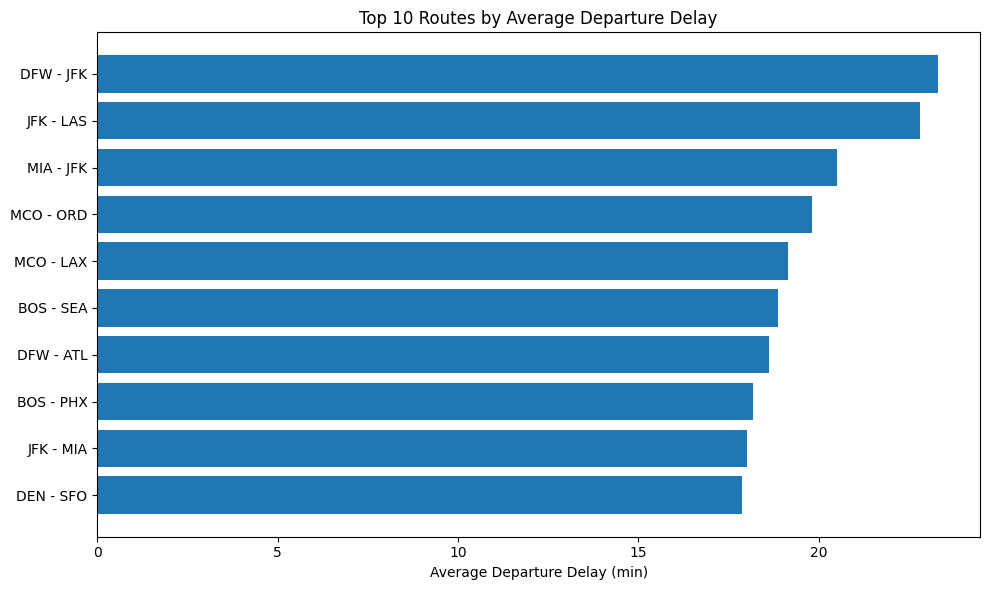

In [7]:
top10_pd = top10.toPandas()
top10_pd['route'] = top10_pd['ORIGIN_AIRPORT'] + " - " + top10_pd['DEST_AIRPORT']

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(top10_pd['route'][::-1], top10_pd['avg_delay'][::-1])  # reverse for descending
plt.xlabel("Average Departure Delay (min)")
plt.title("Top 10 Routes by Average Departure Delay")
plt.tight_layout()
plt.savefig("top10_routes.png", dpi=300)
plt.show()

**DOWNLOAD the files**

In [8]:
top10_pd.to_csv("top10_routes.csv", index=False)
files.download("top10_routes.csv")
files.download("top10_routes.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>